# Exploring correlated data with CCM

In [39]:
import numpy as np
import copy
import shap
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from sympy.solvers.solveset import linsolve
from sympy import Matrix, simplify, symbols


from lib.models import CCM, CBM, MLP, LambdaNet
from lib.train import train_step_standard, train_step_xyz, train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c
from lib.utils import dfs_freeze

# dependence of linear model among correlated variables

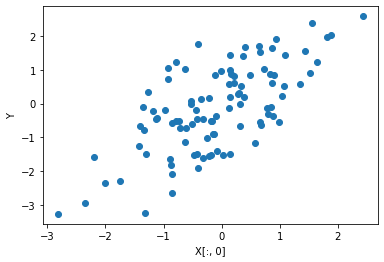

In [2]:
n = 1000
d = 3 # true number of concepts needed for classification
c = 1 # number of expert identified concepts
bs = 100
n_epochs = 200

def genCovX(C, n): # helper function to create N(0, C)
    # C is the covariance matrice (assume to be psd)
    # n is number of examples
    A = np.linalg.cholesky(C)
    d, _ = C.shape
    Z = np.random.randn(n, d)
    X = Z.dot(A.T) 
    return X.astype(np.float32)

def gen_correlated_data(n, d, corr=0.9):
    C = np.zeros((d, d))
    I = np.eye(d).astype(bool)
    C[~I] = corr
    C[I] = 1
    X = genCovX(C, n)
    return torch.from_numpy(X)

X = gen_correlated_data(n, d, corr=0.95)
Y = X[:, 0] + 1 * torch.randn(X.shape[0])
plt.scatter(X.numpy()[:100, 0], Y.numpy()[:100])
plt.xlabel("X[:, 0]")
plt.ylabel("Y")
plt.show()

epoch  19: loss 1.427e+00
epoch  39: loss 1.078e+00
epoch  59: loss 9.951e-01
epoch  79: loss 9.812e-01
epoch  99: loss 9.792e-01
epoch 119: loss 9.786e-01
epoch 139: loss 9.781e-01
epoch 159: loss 9.776e-01
epoch 179: loss 9.771e-01
epoch 199: loss 9.767e-01


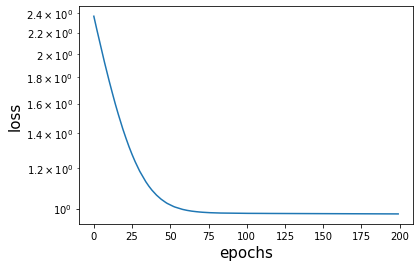

In [3]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 1])

    # train
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=lambda o, y: F.mse_loss(o.view(-1), y))
    if plot: plot_log(log)
    return net

loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
standard_net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [4]:
shap_x = pd.DataFrame(X.numpy()).sample(10)
shap_x

,0,1,2
776,0.531103,0.422232,0.741577
947,0.706438,1.319271,0.964236
637,-0.402413,0.108127,0.013430
539,1.322300,0.664760,1.294732
898,1.106917,0.934055,1.404797
636,0.577500,0.404990,0.595445
166,-2.076391,-1.906551,-2.283167
834,-0.470445,0.058863,-0.449061
449,1.799462,1.788350,1.553515
266,-0.177537,-0.457661,0.397150


            0         1         2        O0
166 -2.076391 -1.906551 -2.283167 -2.059373
834 -0.470445  0.058863 -0.449061 -0.393774
637 -0.402413  0.108127  0.013430 -0.284367
266 -0.177537 -0.457661  0.397150 -0.172207
776  0.531103  0.422232  0.741577  0.511233
636  0.577500  0.404990  0.595445  0.524470
947  0.706438  1.319271  0.964236  0.805773
898  1.106917  0.934055  1.404797  1.077962
539  1.322300  0.664760  1.294732  1.174347
449  1.799462  1.788350  1.553515  1.723327
Explaining O0


  0%|          | 0/10 [00:00<?, ?it/s]

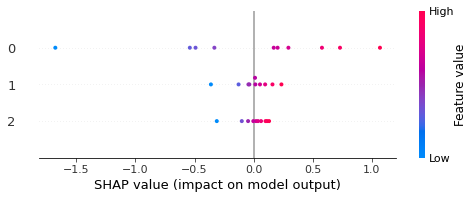

In [5]:
shap_net_x(standard_net, shap_x, bs, instance_idx=None, output_name="O", decimal=10)

# Linear regression

Given $X_1 = Y + n_1$, $X_2 = Y + n_2$ where $n_1 \sim N(0, s_1)$ and $n_2 \sim N(0, s_2)$, I'd expect the linear coefficient to add up to $1$,
but it doesn't for a least square regression setting.

$$min_\theta \mathbb{E}_{(x, y)} (y-\theta^T x)^2$$ 

taking derivative on both sides and set to $0$ simplies to 

$$\left[\begin{matrix}\mathbb{E}(Y^2) + s^{2}_{1} & \mathbb{E}(Y^2) & \mathbb{E}(Y)\\\mathbb{E}(Y^2) & \mathbb{E}(Y^2) + s^{2}_{2} & \mathbb{E}(Y)\\\mathbb{E}(Y) & \mathbb{E}(Y) & 1\end{matrix}\right] \boldsymbol{\theta} = \left[\begin{matrix}\mathbb{E}(Y^2)\\\mathbb{E}(Y^2)\\\mathbb{E}(Y)\end{matrix}\right]$$

In [46]:
from sympy import latex
print(latex(b))

\left[\begin{matrix}\mathbb{E}(Y^2)\\\mathbb{E}(Y^2)\\\mathbb{E}(Y)\end{matrix}\right]


In [40]:
s_y2, s_y, s_s12, s_s22 = symbols('\mathbb{E}(Y^2) \mathbb{E}(Y) s_1^2 s_2^2')

A = Matrix([[s_y2 + s_s12, s_y2, s_y], [s_y2, s_y2 + s_s22, s_y], [s_y, s_y, 1]])
b = Matrix([[s_y2], [s_y2], [s_y]])

result = linsolve((A, b))
result

FiniteSet(((\mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_2^2)/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2), (\mathbb{E}(Y)**2*s_1^2 - \mathbb{E}(Y^2)*s_1^2)/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2), -\mathbb{E}(Y)*s_1^2*s_2^2/(\mathbb{E}(Y)**2*s_1^2 + \mathbb{E}(Y)**2*s_2^2 - \mathbb{E}(Y^2)*s_1^2 - \mathbb{E}(Y^2)*s_2^2 - s_1^2*s_2^2)))

The above is the solution (coefficient for $x_1$, $x_2$, and the bias term) to the system: Note that denominators are the same, also note that coefficient of the first feature is larger when the second feature has larger noise (e.g. $\theta_1 / \theta_2 = s_2^2 / s_1^2$). However, the sum of $\theta_1 + \theta_2 \neq 1$, which is suprising: as shown below:

In [42]:
theta1, theta2, theta3 = r.args[0]
simplify(1- (theta1 + theta2))

s_1^2*s_2^2/(-\mathbb{E}(Y)**2*s_1^2 - \mathbb{E}(Y)**2*s_2^2 + \mathbb{E}(Y^2)*s_1^2 + \mathbb{E}(Y^2)*s_2^2 + s_1^2*s_2^2)

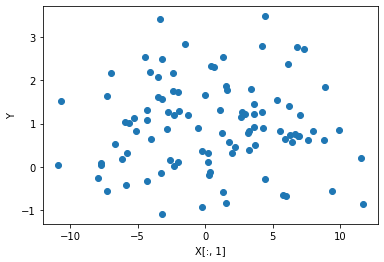

In [6]:
n = 1000
d = 2
s1 = 1 #0.1
s2 = 5 #0.5

Y = torch.randn(n) + 1
x1 = Y + s1 * torch.randn(n)
x2 = Y + s2 * torch.randn(n)
X = torch.vstack([x1, x2]).T

i = 1
plt.scatter(X.numpy()[:100, i], Y.numpy()[:100])
plt.xlabel(f"X[:, {i}]")
plt.ylabel("Y")
plt.show()

epoch  59: loss 4.942e-01
epoch 119: loss 4.805e-01
epoch 179: loss 4.747e-01
epoch 239: loss 4.719e-01
epoch 299: loss 4.705e-01
epoch 359: loss 4.699e-01
epoch 419: loss 4.696e-01
epoch 479: loss 4.694e-01
epoch 539: loss 4.694e-01
epoch 599: loss 4.693e-01


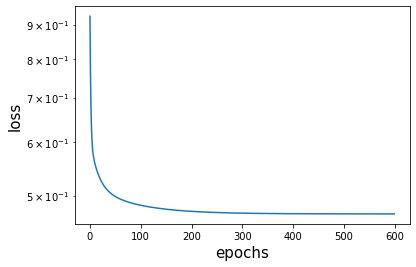

In [7]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 1])

    # train
    opt = optim.SGD(net.parameters(), lr=0.005)
    # opt = optim.SGD(net.parameters(), lr=0.001)
    # opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=lambda o, y: F.mse_loss(o.view(-1), y))
    if plot: plot_log(log)
    return net

bs = n # gradient descent
n_epochs = 600

loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
net = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [8]:
print(net.classifier[0].weight)
print(net.classifier[0].weight.sum())

print(net.classifier[0].bias)

Parameter containing:
tensor([[0.5035, 0.0145]], requires_grad=True)
tensor(0.5181, grad_fn=<SumBackward0>)
Parameter containing:
tensor([0.4355], requires_grad=True)


In [9]:
a = 1 # E(y^2)
b = s1**2 # E(s1^2)
c = s2**2 # E(s2^2)

print('theta 1', a*c / (b*c + a*b + a*c))
print('theta 2', a*b / (b*c + a*b + a*c))
print('t1 + t2', (a*b + a*c)/ (b*c + a*b + a*c))

print(b*c / (b*c + a*b + a*c))

theta 1 0.49019607843137253
theta 2 0.0196078431372549
t1 + t2 0.5098039215686274
0.49019607843137253
